# Time Series Project - monthly housing sales by zip code

For this analysis I will be working as a Data Scientist for a financial investment firm that is looking for short-term real estate investment opportunities for it's smaller investors to diversify their investment profiles. I will be analyzing median monthly housing sales prices for over 14,000 United States zip codes and choosing the best areas to further analyze for potential investment. I will then forecast future real estate prices in those zip codes.

## Dataset information

This data represents median monthly housing sales prices for 265 zip codes over the period of April 1996 through April 2018 as reported by Zillow.

Each row represents a unique zip code. Each record contains location info and median housing sales prices for each month.

There are 14,723 rows and 272 variables:

- **_RegionID_**: Unique index, 58196 through 753844
- **_RegionName_**: Unique Zip Code, 1001 through 99901
- **_City_**: City in which the zip code is located
- **_State_**: State in which the zip code is located
- **_Metro_**: Metropolitan Area in which the zip code is located
- **_CountyName_**: County in which the zip code is located
- **_SizeRank_**: Numerical rank of size of zip code, ranked 1 through 14723
- **_1996-04 through 2018-04_**: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code


Some ideas for exploration:

1. Look at ROI for each zip code, over the whole dataset, avg for each year, 3 year avg, 5 year avg, 10 year avg
2. Plot median sales price against ROI to get quadrants for comparison
3. Which zips have highest and lowest ROI?
4. Business case - choose highest ROI for small investors

## Data Preprocessing

### Import and basic info

**Output** - zillow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from user_functions import *
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',    
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',    
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

'''font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!'''

"font = {'family' : 'normal',\n        'weight' : 'bold',\n        'size'   : 22}\n\nmatplotlib.rc('font', **font)\n\n# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!"

In [3]:
zillow = pd.read_csv('zillow_data.csv')
zillow.info()
# I see 4 string object columns, not sure why 49 are int and others float.
# Most column names will be changed to datetime
# Zip codes are actually not continuous so maybe they should be strings
# Don't know if RegionID has any meaning, seems unneeded if zip codes are unique.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
# Data appears to be sorted by SizeRank, largest to smallest
# I see some Nan values in Metro
# And some 4 digit zip codes which I assume should start with a zero
zillow.tail(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
14713,59187,3765,Haverhill,NH,Claremont,Grafton,14714,80800.0,80100.0,79400.0,...,119800,120000,120800,121600,122600,123400,124400,125500,126600,127500
14714,94711,84781,Pine Valley,UT,St. George,Washington,14715,135900.0,136300.0,136600.0,...,241100,243200,244300,248900,254600,257600,258000,260600,264700,266800
14715,62556,12429,Esopus,NY,Kingston,Ulster,14716,78300.0,78300.0,78200.0,...,164200,166600,170000,171000,170700,171300,172400,173600,175800,177500
14716,99032,97028,Rhododendron,OR,Portland,Clackamas,14717,136200.0,136600.0,136800.0,...,332600,332900,335600,338900,340500,341000,342300,345000,348000,349300
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122200,122700,122300,122000,122200,122800,123200,123200,120700,117700
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400
14722,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,176400.0,176300.0,176100.0,...,333800,336400,339700,343800,346800,348900,350400,353000,356000,357200


In [6]:
# Can see missing values in Metro
zillow.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [7]:
# There will be lots of other missing values in the time series data
zillow.isna().sum().sum()

157934

### Analyze 'RegionID'

All unique, cast to string

In [8]:
# Starting analysis of first variable, RegionID
# 14723 unique values
print(zillow.RegionID.value_counts())
print(zillow.RegionID.nunique())
print(zillow.RegionID.min())
print(zillow.RegionID.max())

73724     1
70551     1
99221     1
76688     1
82829     1
         ..
71176     1
91654     1
65029     1
100380    1
98304     1
Name: RegionID, Length: 14723, dtype: int64
14723
58196
753844


In [9]:
zillow[zillow.RegionID >= 200000]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
444,417444,85142,Queen Creek,AZ,Phoenix,Pinal,445,117400.0,115500.0,113800.0,...,281200,283700,286200,288200,289900,291700,293700,296300,299700,302200
750,399576,33578,Riverview,FL,Tampa,Hillsborough,751,74700.0,74200.0,73800.0,...,189600,190100,190400,191400,192900,194200,195000,196200,197600,198800
863,417437,85122,Casa Grande,AZ,Phoenix,Pinal,864,82700.0,83500.0,84300.0,...,152600,155000,157200,158400,158700,158900,159300,160400,162600,164700
926,399724,77407,Richmond,TX,Houston,Fort Bend,927,119800.0,119600.0,119700.0,...,247100,247200,247100,247000,246600,246700,247500,248900,249600,249500
1101,399638,78665,Round Rock,TX,Austin,Williamson,1102,160700.0,160300.0,160100.0,...,258000,257400,257700,258400,258900,258900,258900,259500,260100,259900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12263,399644,80927,Colorado Springs,CO,Colorado Springs,El Paso,12264,147800.0,148500.0,149100.0,...,335900,335700,335200,334700,334900,336200,339400,344900,351500,355300
12407,399666,89034,Mesquite,NV,Las Vegas,Clark,12408,196000.0,196000.0,195900.0,...,289400,294500,299800,304700,308100,311700,315500,319500,323600,326600
13498,417445,85145,Marana,AZ,Tucson,Pima,13499,NaN,NaN,NaN,...,141000,143800,145900,146600,147400,148900,150600,151800,152300,152700
14181,399514,3285,Thornton,NH,Claremont,Grafton,14182,92000.0,91800.0,91500.0,...,200500,204900,208600,211600,213200,215000,217100,219500,221500,222400


In [10]:
# It doesn't seem to mean anything and all are unique.  Lets make them strings.
zillow.RegionID = zillow.RegionID.astype('string')

In [11]:
zillow.RegionID.unique()

<StringArray>
['84654', '90668', '91982', '84616', '93144', '91733', '61807', '84640',
 '91940', '97564',
 ...
 '59187', '94711', '62556', '99032', '62697', '58333', '59107', '75672',
 '93733', '95851']
Length: 14723, dtype: string

### Analyze 'Region Name'

**Output** - 

Cast to string, add 0 to 4 digit zip codes

In [12]:
# Now look at RegionName, this is the zip code
zillow.RegionName.value_counts() # 14723 unique values

55324    1
74561    1
73538    1
31546    1
82070    1
        ..
75182    1
55343    1
1450     1
73129    1
65536    1
Name: RegionName, Length: 14723, dtype: int64

In [13]:
# All zip codes are unique.  I will cast to string and add 0 to the four digit one.
zillow.RegionName = zillow.RegionName.astype('string')

In [14]:
for i in range(len(zillow)):
    zillow.RegionName[i] = zillow.RegionName[i].rjust(5, '0')

In [15]:
zillow.RegionName.min()

'01001'

In [16]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(47), object(4), string(2)
memory usage: 30.6+ MB


In [17]:
zillow[['RegionName', 'State']].sort_values(by=['RegionName'])

,RegionName,State
5850,01001,MA
4199,01002,MA
11213,01005,MA
6850,01007,MA
14547,01008,MA
...,...,...
4526,99709,AK
8438,99712,AK
4106,99801,AK
8658,99835,AK


### Analyze 'City'



In [18]:
# There are 7554 unique values.
zillow.City.nunique()

7554

### Analyze 'State'



In [19]:
zillow.State.nunique()

51

In [20]:
# Includes DC
zillow.State.unique()

array(['IL', 'TX', 'NY', 'CA', 'FL', 'TN', 'NC', 'GA', 'DC', 'MO', 'OK',
       'AZ', 'NJ', 'MD', 'VA', 'WA', 'OH', 'MI', 'MA', 'KS', 'NM', 'CT',
       'NV', 'PA', 'CO', 'OR', 'IN', 'SC', 'KY', 'AR', 'ND', 'MN', 'AL',
       'DE', 'LA', 'MS', 'ID', 'MT', 'HI', 'WI', 'UT', 'ME', 'SD', 'WV',
       'IA', 'RI', 'NE', 'WY', 'AK', 'NH', 'VT'], dtype=object)

### Analyze 'Metro'

Fillna with None

In [21]:
print(zillow.Metro.value_counts())
print(zillow.Metro.nunique())

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
                                 ... 
Alamogordo                          1
Starkville                          1
Salina                              1
Gallup                              1
Grants                              1
Name: Metro, Length: 701, dtype: int64
701


In [22]:
zillow.Metro[151]

nan

In [23]:
zillow.Metro.fillna('None', inplace=True)

In [24]:
zillow.Metro.value_counts()

None                              1043
New York                           779
Los Angeles-Long Beach-Anaheim     347
Chicago                            325
Philadelphia                       281
                                  ... 
Alamogordo                           1
Starkville                           1
Salina                               1
Gallup                               1
Grants                               1
Name: Metro, Length: 702, dtype: int64

### Analyze 'CountyName'



In [25]:
zillow.CountyName.value_counts()

Los Angeles    264
Jefferson      175
Orange         166
Washington     164
Montgomery     159
              ... 
Autauga          1
Power            1
Custer           1
Cuming           1
Somervell        1
Name: CountyName, Length: 1212, dtype: int64

In [26]:
zillow.CountyName.isna().sum()

0

### Analyze 'SizeRank'



In [27]:
zillow.SizeRank.unique()

array([    1,     2,     3, ..., 14721, 14722, 14723], dtype=int64)

### Analyze missing sales values

In [28]:
# 1039 zip codes don't have full data
zillow[zillow['1996-04'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
36,61796,10456,New York,NY,New York,Bronx,37,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
105,84613,60611,Chicago,IL,Chicago,Cook,106,NaN,NaN,NaN,...,1475200,1473900,1469500,1472100,1477800,1486000,1497300,1508600,1508100,1493200
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2673300,2696700,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300
232,69533,27834,Greenville,NC,Greenville,Pitt,233,NaN,NaN,NaN,...,100100,98700,97400,96100,95900,96300,97000,98300,100200,101200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14703,94323,83821,Coolin,ID,Sandpoint,Bonner,14704,NaN,NaN,NaN,...,550500,550700,542900,539100,547100,555700,561500,558600,547800,540400
14705,79929,49768,Paradise,MI,Sault Ste. Marie,Chippewa,14706,NaN,NaN,NaN,...,86700,86900,87000,87200,87500,88100,88100,87500,86900,86700
14706,59046,03215,Waterville Valley,NH,Claremont,Grafton,14707,NaN,NaN,NaN,...,786000,780900,774100,767800,778300,796800,808100,811600,806500,796600
14707,69681,28039,East Spencer,NC,Charlotte,Rowan,14708,NaN,NaN,NaN,...,27300,26400,25500,25100,25100,25600,25800,26600,27700,28300


In [29]:
# But all zip codes have some data
zillow[zillow['2018-04'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [30]:
# I need to find an ROI that I can compare them all on
# Find the zips with the least data
for col in reversed(zillow.columns):
    if zillow[col].isna().sum() >0:
        print(col)
        break

2014-06


In [31]:
# 56 zip codes only go back to 07-2014
zillow[zillow['2014-06'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2946,73623,35810,Huntsville,AL,Huntsville,Madison,2947,NaN,NaN,NaN,...,61000,61000,61100,61900,62800,63200,63700,65200,67500,69400
3330,58630,02116,Boston,MA,Boston,Suffolk,3331,NaN,NaN,NaN,...,1931100,1995600,2031100,2049600,2057800,2064500,2037600,2056900,2106500,2136500
6153,73629,35816,Huntsville,AL,Huntsville,Madison,6154,NaN,NaN,NaN,...,61500,62500,62800,63300,64100,65100,66600,68700,70400,71300
7587,78091,46320,Hammond,IN,Chicago,Lake,7588,NaN,NaN,NaN,...,66000,67900,68200,68700,69600,69400,68500,68500,68200,67200
7635,78566,47371,Portland,IN,None,Jay,7636,NaN,NaN,NaN,...,86300,86600,87400,88200,89100,90300,90400,89100,88000,88100
8263,88723,70647,Iowa,LA,Lake Charles,Calcasieu,8264,NaN,NaN,NaN,...,111600,117900,125300,128900,129600,130800,132100,132700,132400,132300
8338,73630,35824,Huntsville,AL,Huntsville,Madison,8339,NaN,NaN,NaN,...,217200,216800,216300,215100,215700,218200,222000,226200,230300,231800
8668,75206,39202,Jackson,MS,Jackson,Hinds,8669,NaN,NaN,NaN,...,152700,154300,155800,157500,158100,158300,158400,157900,156600,155300
8746,90561,74857,Norman,OK,Oklahoma City,Cleveland,8747,NaN,NaN,NaN,...,141800,141800,141700,141700,142000,143600,145600,145700,143900,141900
8780,78097,46327,Hammond,IN,Chicago,Lake,8781,NaN,NaN,NaN,...,75200,74600,73200,72500,72800,73200,72700,72900,74000,74400


## EDA on zip codes

In [32]:
# Create a 4 year ROI since that is the most data we have for some zips
zillow['4_yr_ROI'] = (zillow['2018-04'] - zillow['2014-07'])/(zillow['2014-07'])
zillow['4_yr_ROI']

0        0.154346
1        0.338046
2        0.134847
3        0.119294
4        0.066725
           ...   
14718    0.103903
14719    0.239297
14720    0.280230
14721    0.234256
14722    0.293266
Name: 4_yr_ROI, Length: 14723, dtype: float64

In [33]:
# Lowest values
zillow.sort_values('4_yr_ROI').head()[['RegionName','City','State','4_yr_ROI']]

,RegionName,City,State,4_yr_ROI
11391,54230,Reedsville,WI,-0.388060
12436,45390,Union City,OH,-0.335992
13485,45346,New Madison,OH,-0.282334
13078,53015,Cleveland,WI,-0.265185
4294,45331,Greenville,OH,-0.249827


In [34]:
# Highest values
zillow.sort_values('4_yr_ROI',ascending=False).head()[['RegionName','City','State','4_yr_ROI']]

,RegionName,City,State,4_yr_ROI
13409,27980,Hertford,NC,1.948770
842,30032,Candler-Mcafee,GA,1.489011
6563,15201,Pittsburgh,PA,1.261294
4554,33805,Lakeland,FL,1.233115
6105,37210,Nashville,TN,1.142857


In [35]:
# Check most recent one year ROI
zillow['recent_1_yr_ROI'] = (zillow['2018-04'] - zillow['2017-04'])/(zillow['2017-04'])
zillow['recent_1_yr_ROI']

0        0.041852
1        0.057162
2        0.030937
3        0.019103
4        0.029661
           ...   
14718   -0.010402
14719    0.162120
14720    0.104305
14721    0.121350
14722    0.100092
Name: recent_1_yr_ROI, Length: 14723, dtype: float64

In [36]:
# Lowest values
zillow.sort_values('recent_1_yr_ROI').head()[['RegionName','City','State','recent_1_yr_ROI']]

,RegionName,City,State,recent_1_yr_ROI
14618,66023,Effingham,KS,-0.218135
7286,70583,Scott,LA,-0.197955
11914,71023,Doyline,LA,-0.186260
6445,30642,Greensboro,GA,-0.170560
9457,70090,Vacherie,LA,-0.167689


In [37]:
# Highest values
zillow.sort_values('recent_1_yr_ROI',ascending=False).head()[['RegionName','City','State','recent_1_yr_ROI']]

,RegionName,City,State,recent_1_yr_ROI
4211,07106,Newark,NJ,0.508078
13409,27980,Hertford,NC,0.474385
3285,19601,Reading,PA,0.437500
3540,07103,Newark,NJ,0.435213
4309,29405,North Charleston,SC,0.431034


In [38]:
# Find avg one year ROI over past 3 years
def average_one_year_ROI(df):
    average_one_year_ROI = []
    for i in range(len(df)):
        year_1_ROI = df['recent_1_yr_ROI'][i]
        year_2_ROI = (df.iloc[i,-15] - df.iloc[i,-27])/df.iloc[i,-27]
        year_3_ROI = (df.iloc[i,-27] - df.iloc[i,-39])/df.iloc[i,-39]
        avg_ROI = (year_1_ROI + year_2_ROI + year_3_ROI)/3
        average_one_year_ROI.append(avg_ROI)
    return average_one_year_ROI    

In [39]:
zillow['avg_one_yr_ROI'] = average_one_year_ROI(zillow)

In [40]:
# Lowest values
zillow.sort_values('avg_one_yr_ROI').head()[['RegionName','City','State','avg_one_yr_ROI']]

,RegionName,City,State,avg_one_yr_ROI
11391,54230,Reedsville,WI,-0.135889
12436,45390,Union City,OH,-0.129479
13485,45346,New Madison,OH,-0.109924
13078,53015,Cleveland,WI,-0.103355
4294,45331,Greenville,OH,-0.098901


In [41]:
# Highest values
zillow.sort_values('avg_one_yr_ROI', ascending=False).head()[['RegionName','City','State','avg_one_yr_ROI','2018-04']]

,RegionName,City,State,avg_one_yr_ROI,2018-04
13409,27980,Hertford,NC,0.355009,143900
842,30032,Candler-Mcafee,GA,0.273701,135900
466,19134,Philadelphia,PA,0.268561,46600
1821,28208,Charlotte,NC,0.250809,113400
2661,33705,Saint Petersburg,FL,0.247735,177300


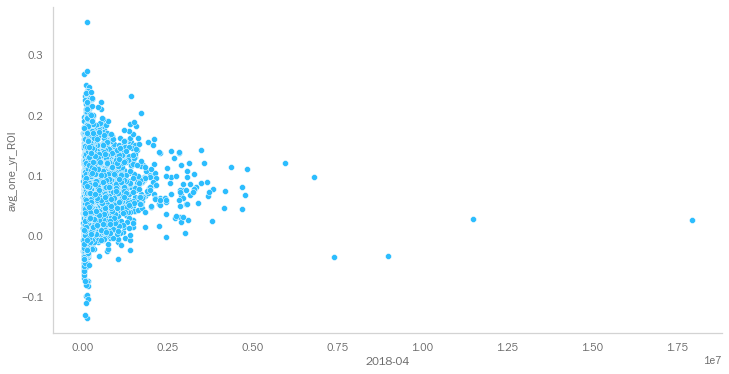

In [42]:
# Plotting median home price versus avg ROI. Some crazy 20 million dollar home values in New York.
plt.figure(figsize = (12,6))
sns.scatterplot(data=zillow, x='2018-04', y='avg_one_yr_ROI')
plt.savefig('Images/scatterplot1.png');

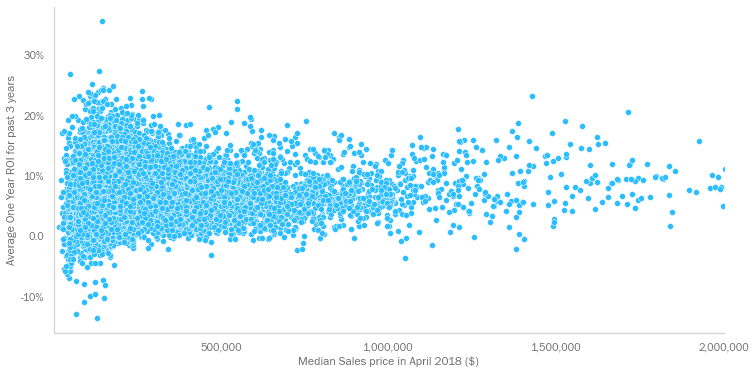

In [43]:
# Eliminate the high outliers
plt.figure(figsize = (12,6))
sns.scatterplot(data=zillow, x='2018-04', y='avg_one_yr_ROI')
plt.xlim(0,2000000)
plt.xticks([500000,1000000,1500000,2000000],['500,000','1,000,000','1,500,000','2,000,000'])
plt.xlabel('Median Sales price in April 2018 ($)')
plt.ylabel('Average One Year ROI for past 3 years')
plt.yticks([-0.10, 0, 0.10, 0.20, 0.30], ['-10%', '0.0', '10%', '20%', '30%'])
plt.savefig('Images/scatterplot2.png');

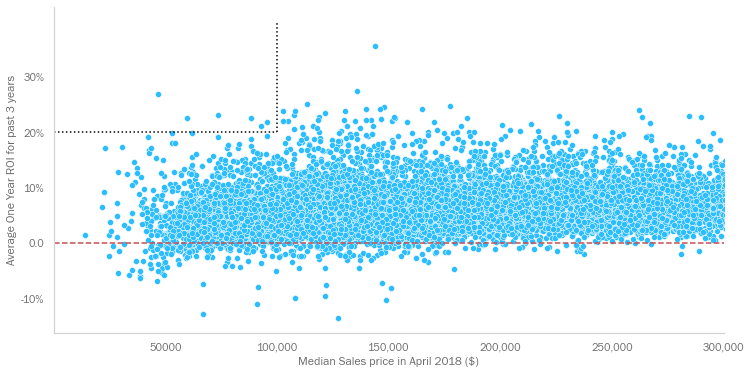

In [44]:
# Further reduce price
# Per my business case, I am looking for highest ROI for small investors
plt.figure(figsize = (12,6))
sns.scatterplot(data=zillow, x='2018-04', y='avg_one_yr_ROI')
plt.xlim(0,300000)
plt.xticks([50000,100000,150000,200000,250000,300000],['50000','100,000','150,000','200,000','250,000','300,000'])
plt.xlabel('Median Sales price in April 2018 ($)')
plt.ylabel('Average One Year ROI for past 3 years')
plt.hlines(0, 0, 300000, color='r', linestyles='dashed')
plt.hlines(.20, 0, 100000, color = 'black', linestyles='dotted')
plt.vlines(100000,.2,.4,color='black', linestyles='dotted')
plt.yticks([-0.10, 0, 0.10, 0.20, 0.30], ['-10%', '0.0', '10%', '20%', '30%'])
plt.savefig('Images/scatterplot3.png');

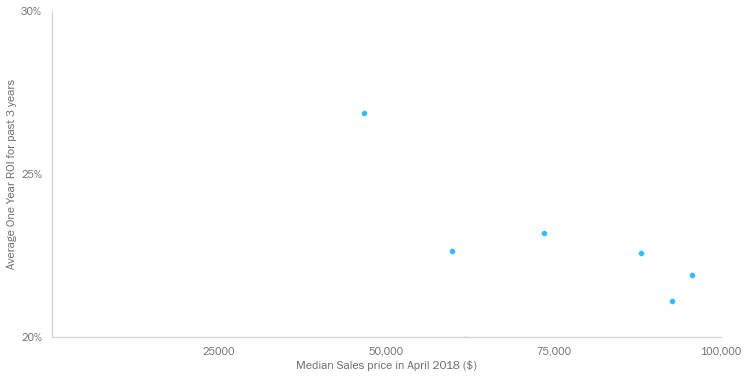

In [45]:
# Zoom in
plt.figure(figsize = (12,6))
sns.scatterplot(data=zillow, x='2018-04', y='avg_one_yr_ROI')
plt.xlim(0,100000)
plt.ylim(.20,.30)
plt.xticks([25000, 50000,75000,100000],['25000','50,000','75,000','100,000'])
plt.xlabel('Median Sales price in April 2018 ($)')
plt.ylabel('Average One Year ROI for past 3 years')
# plt.hlines(0, 0, 300000, color='r', linestyles='dashed')
# plt.hlines(.20, 0, 100000, color = 'black', linestyles='dotted')
# plt.vlines(100000,.2,.4,color='black', linestyles='dotted')
plt.yticks([0.20, 0.25, 0.30], ['20%', '25%', '30%'])
plt.savefig('Images/scatterplot4.png');

## Subset data on top zip codes

In [46]:
# Choose zips with 'current' price under $100,000 and avg ROI greater than 20%
zillow_top = zillow[(zillow['2018-04'] < 100000) & (zillow['avg_one_yr_ROI'] > 0.20)]
zillow_top

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,4_yr_ROI,recent_1_yr_ROI,avg_one_yr_ROI
466,65801,19134,Philadelphia,PA,Philadelphia,Philadelphia,467,27600.0,27500.0,27500.0,...,39600,40600,41600,42600,44000,45700,46600,0.834646,0.259459,0.268561
1754,78022,46203,Indianapolis,IN,Indianapolis,Marion,1755,NaN,NaN,NaN,...,67000,66600,67400,69200,70600,71800,73500,1.047354,0.137771,0.231818
2199,71793,32114,Daytona Beach,FL,Daytona Beach,Volusia,2200,47700.0,48000.0,48300.0,...,85500,86700,87900,89000,90400,91900,92600,0.909278,0.169192,0.210909
3853,76575,43206,Columbus,OH,Columbus,Franklin,3854,NaN,NaN,NaN,...,69400,71800,75700,78800,81300,84500,88100,0.984234,0.409600,0.225806
4293,87104,66104,Kansas City,KS,Kansas City,Wyandotte,4294,41300.0,41200.0,41200.0,...,51600,54200,55700,55700,55900,57800,59800,0.986711,0.300000,0.226380
5682,74373,37411,Chattanooga,TN,Chattanooga,Hamilton,5683,54800.0,55000.0,55200.0,...,87400,89200,90500,91700,93500,95000,95600,0.623090,0.283221,0.219015


In [47]:
zillow_top[['RegionName', 'City','State','Metro', 'SizeRank','2018-04','avg_one_yr_ROI']]

,RegionName,City,State,Metro,SizeRank,2018-04,avg_one_yr_ROI
466,19134,Philadelphia,PA,Philadelphia,467,46600,0.268561
1754,46203,Indianapolis,IN,Indianapolis,1755,73500,0.231818
2199,32114,Daytona Beach,FL,Daytona Beach,2200,92600,0.210909
3853,43206,Columbus,OH,Columbus,3854,88100,0.225806
4293,66104,Kansas City,KS,Kansas City,4294,59800,0.226380
5682,37411,Chattanooga,TN,Chattanooga,5683,95600,0.219015


## Clustering?  

What info does this really give me?

## Convert to date types

In [48]:
# Function provided in starter notebook
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[:], format='%Y-%m')

In [49]:
# These are my date columns only.  Running them through the function.
zillow_top_date_df = zillow_top.iloc[:,7:-3]
zillow_top_date_df.columns = list(get_datetimes(zillow_top_date_df))
zillow_top_date_df

,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
466,27600.0,27500.0,27500.0,27400.0,27400.0,27300.0,27300.0,27200.0,27200.0,27300.0,...,39000,39100,39100,39600,40600,41600,42600,44000,45700,46600
1754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66700,66700,66900,67000,66600,67400,69200,70600,71800,73500
2199,47700.0,48000.0,48300.0,48400.0,48500.0,48500.0,48500.0,48400.0,48400.0,48400.0,...,82300,83300,84300,85500,86700,87900,89000,90400,91900,92600
3853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67600,68600,68800,69400,71800,75700,78800,81300,84500,88100
4293,41300.0,41200.0,41200.0,41100.0,41000.0,40800.0,40700.0,40500.0,40500.0,40500.0,...,47300,47900,49700,51600,54200,55700,55700,55900,57800,59800
5682,54800.0,55000.0,55200.0,55400.0,55700.0,55900.0,56200.0,56400.0,56700.0,57000.0,...,82300,84500,85800,87400,89200,90500,91700,93500,95000,95600


In [50]:
# Now put the df back together, 7 info columns, 3 feature columns of ROI calculation, then date columns.
zillow_top_date = pd.concat([zillow_top.iloc[:, :7], zillow_top.iloc[:, -3:], zillow_top_date_df], axis=1)
zillow_top_date

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,4_yr_ROI,recent_1_yr_ROI,avg_one_yr_ROI,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
466,65801,19134,Philadelphia,PA,Philadelphia,Philadelphia,467,0.834646,0.259459,0.268561,...,39000,39100,39100,39600,40600,41600,42600,44000,45700,46600
1754,78022,46203,Indianapolis,IN,Indianapolis,Marion,1755,1.047354,0.137771,0.231818,...,66700,66700,66900,67000,66600,67400,69200,70600,71800,73500
2199,71793,32114,Daytona Beach,FL,Daytona Beach,Volusia,2200,0.909278,0.169192,0.210909,...,82300,83300,84300,85500,86700,87900,89000,90400,91900,92600
3853,76575,43206,Columbus,OH,Columbus,Franklin,3854,0.984234,0.409600,0.225806,...,67600,68600,68800,69400,71800,75700,78800,81300,84500,88100
4293,87104,66104,Kansas City,KS,Kansas City,Wyandotte,4294,0.986711,0.300000,0.226380,...,47300,47900,49700,51600,54200,55700,55700,55900,57800,59800
5682,74373,37411,Chattanooga,TN,Chattanooga,Hamilton,5683,0.623090,0.283221,0.219015,...,82300,84500,85800,87400,89200,90500,91700,93500,95000,95600


In [51]:
zillow_top_date.isna().sum().sum()

324

## Reshape from wide to long format

In [52]:
# Create a separate data frame for each of the 6 top zip codes.
Philly = zillow_top_date[zillow_top_date['RegionName']=='19134']
Indy = zillow_top_date[zillow_top_date['RegionName']=='46203']
Daytona = zillow_top_date[zillow_top_date['RegionName']=='32114']
Columbus = zillow_top_date[zillow_top_date['RegionName']=='43206']
KC = zillow_top_date[zillow_top_date['RegionName']=='66104']
Chattanooga = zillow_top_date[zillow_top_date['RegionName']=='37411']

In [53]:
# Columbus and Indy have missing data.  I don't want to back fill multiple years worth of data.
# I'd rather slice off what I have and backfill only occasional missing data
Indy.isna().sum().sum()

111

In [54]:
Indy.columns[Indy.isnull().any()] # Indy begins recording data at 2005-07-01

Index([1996-04-01 00:00:00, 1996-05-01 00:00:00, 1996-06-01 00:00:00,
       1996-07-01 00:00:00, 1996-08-01 00:00:00, 1996-09-01 00:00:00,
       1996-10-01 00:00:00, 1996-11-01 00:00:00, 1996-12-01 00:00:00,
       1997-01-01 00:00:00,
       ...
       2004-09-01 00:00:00, 2004-10-01 00:00:00, 2004-11-01 00:00:00,
       2004-12-01 00:00:00, 2005-01-01 00:00:00, 2005-02-01 00:00:00,
       2005-03-01 00:00:00, 2005-04-01 00:00:00, 2005-05-01 00:00:00,
       2005-06-01 00:00:00],
      dtype='object', length=111)

In [55]:
Columbus.columns[Columbus.isnull().any()] # Columbus begins recording data at 2014-01-01

Index([1996-04-01 00:00:00, 1996-05-01 00:00:00, 1996-06-01 00:00:00,
       1996-07-01 00:00:00, 1996-08-01 00:00:00, 1996-09-01 00:00:00,
       1996-10-01 00:00:00, 1996-11-01 00:00:00, 1996-12-01 00:00:00,
       1997-01-01 00:00:00,
       ...
       2013-03-01 00:00:00, 2013-04-01 00:00:00, 2013-05-01 00:00:00,
       2013-06-01 00:00:00, 2013-07-01 00:00:00, 2013-08-01 00:00:00,
       2013-09-01 00:00:00, 2013-10-01 00:00:00, 2013-11-01 00:00:00,
       2013-12-01 00:00:00],
      dtype='object', length=213)

In [56]:
Indy_notnull = Indy[Indy.columns.drop(Indy.columns[Indy.isnull().any()])]
Columbus_notnull = Columbus[Columbus.columns.drop(Columbus.columns[Columbus.isnull().any()])]

In [57]:
Indy_notnull

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,4_yr_ROI,recent_1_yr_ROI,avg_one_yr_ROI,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
1754,78022,46203,Indianapolis,IN,Indianapolis,Marion,1755,1.047354,0.137771,0.231818,...,66700,66700,66900,67000,66600,67400,69200,70600,71800,73500


In [58]:
def melt_data(list_of_dfs): # changed to take in a list of dataframes for scalability
    """Convert list of time series dataframes into melted format"""
    return_list = []
    for df in list_of_dfs:
        melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName',
                                     'SizeRank', '4_yr_ROI', 'recent_1_yr_ROI','avg_one_yr_ROI'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#         melted = melted.dropna(subset=['value'])
        melted = melted.bfill() # I'm adding this to try backfill instead of dropna
        return_list.append(melted.groupby('time').aggregate({'value':'mean'}))
    return return_list

In [59]:
zips_to_melt = [Philly, Indy_notnull, Daytona, Columbus_notnull, KC, Chattanooga]
Philly_melted, Indy_melted, Daytona_melted, Columbus_melted, KC_melted, Chattanooga_melted = melt_data(zips_to_melt)

Indy_melted

,value
time,
2005-07-01,73600.0
2005-08-01,74700.0
2005-09-01,75700.0
2005-10-01,76600.0
2005-11-01,77200.0
...,...
2017-12-01,67400.0
2018-01-01,69200.0
2018-02-01,70600.0


## Visualize time series plots

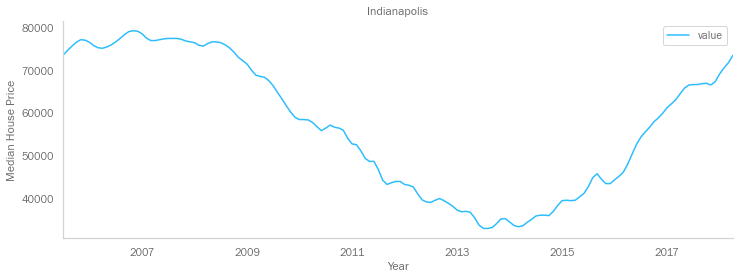

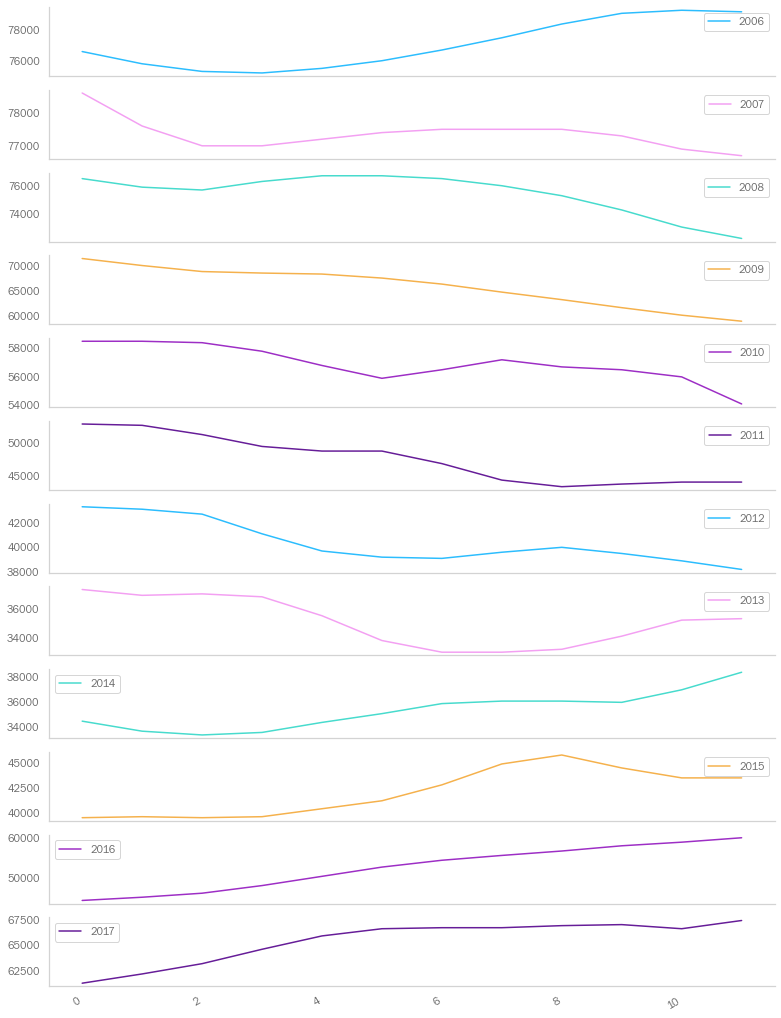

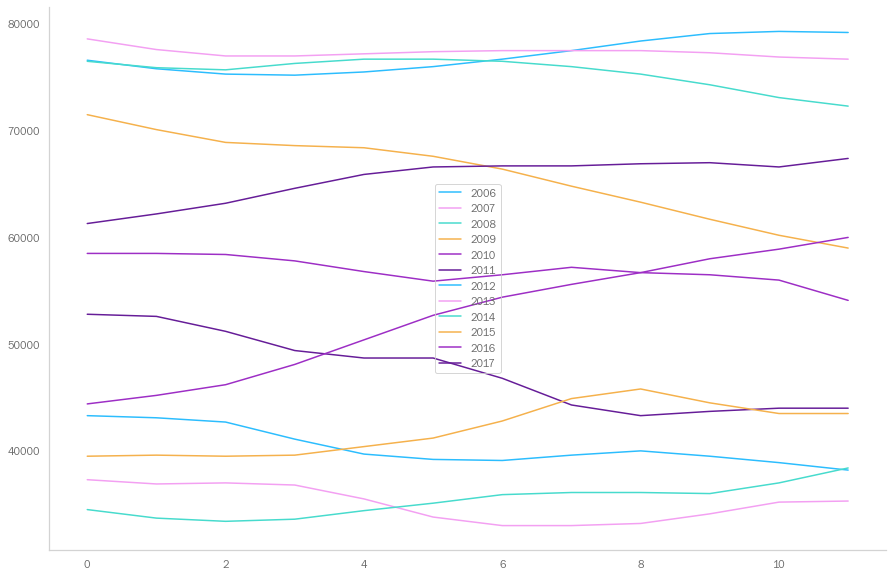

In [60]:
visualize_time_series(Indy_melted, 'Indianapolis') # functioned defined in user_functions.py

# I don't really find the annual breakout graphs to be that helpful for visualization

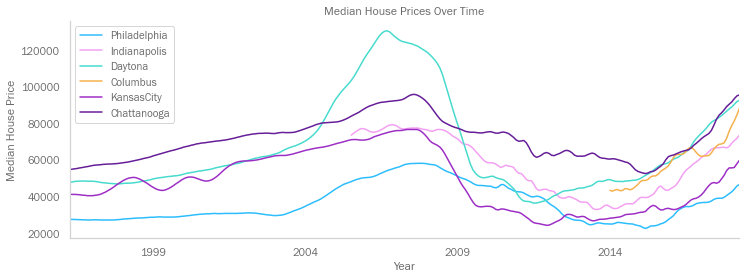

In [61]:
# Plot all 6 chosen zip codes together
all_dfs = [Philly_melted, Indy_melted, Daytona_melted, Columbus_melted, KC_melted, Chattanooga_melted]
names = ['Philadelphia','Indianapolis','Daytona','Columbus','KansasCity','Chattanooga']
visualize_all_series(all_dfs, names) # Function defined in user_functions.py

## Checking for trends, stationarity, seasonality
<pre>
Best Log Transformed Differences (0-5) with p-values

{'Philadelphia': (1, 0.03194585744150177),
 'Indianapolis': (2, 0.7150685269034184),
 'Daytona': (5, 0.15351111071221946),
 'Columbus': (4, 0.018148301922587158),
 'Kansas City': (1, 0.14000751949106677),
 'Chattanooga': (1, 0.14039677392972233)}
 </pre>

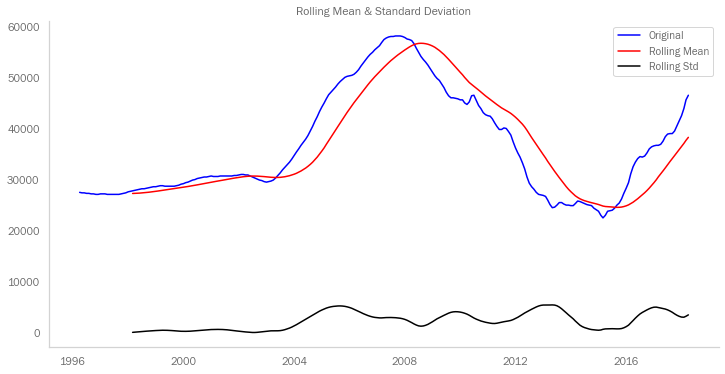

Results of Dickey-Fuller Test: 

Test Statistic                  -0.288166
p-value                          0.927164
#Lags Used                       0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [62]:
stationarity_check(Philly_melted) # Function defined in user_functions.py
# p-value is greater than .05 (it is .927!) so the series is not stationary

In [63]:
#See what differencing does
data_diff = Philly_melted.diff(periods=1)
data_diff.head(10)

,value
time,
1996-04-01,NaN
1996-05-01,-100.0
1996-06-01,0.0
1996-07-01,-100.0
1996-08-01,0.0
1996-09-01,-100.0
1996-10-01,0.0
1996-11-01,-100.0
1996-12-01,0.0


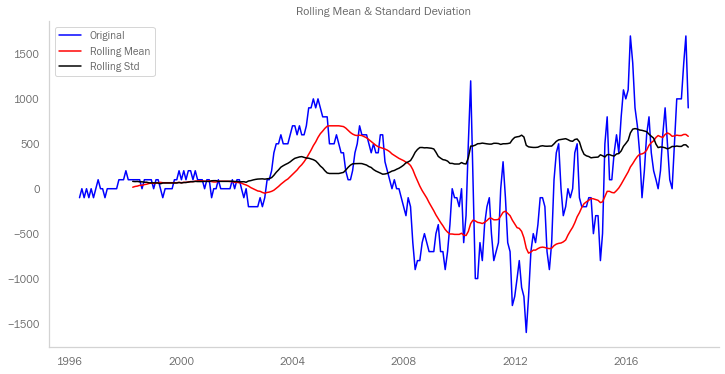

Results of Dickey-Fuller Test: 

Test Statistic                  -2.422182
p-value                          0.135573
#Lags Used                       8.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


In [64]:
stationarity_check(data_diff[1:])
# p-value is down to .13 but still not stationary

In [65]:
from statsmodels.tsa.stattools import adfuller

def find_best_difference(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])

find_best_difference(Philly_melted)

0 nan
1 0.1355732285119607
2 0.11919275051848399
3 0.46881217920610363
4 0.06815812325627901
5 0.5883509233410241
6 0.6625687149487411
7 0.6594311981817602
8 0.6800038226664793
9 0.6534124137040307
10 0.4258803417746362
11 0.37733392014565237
12 0.35832937865646863
13 0.5086076402133188
14 0.7541136387628624
15 0.774362568776317
16 0.9158068216563182
17 0.6293119733269782
18 0.7908159564611525
19 0.7702364848871605
20 0.6899295894240023
21 0.5526525850677468
22 0.3944823143309037
23 0.15231458968681078
24 0.25381820081799567


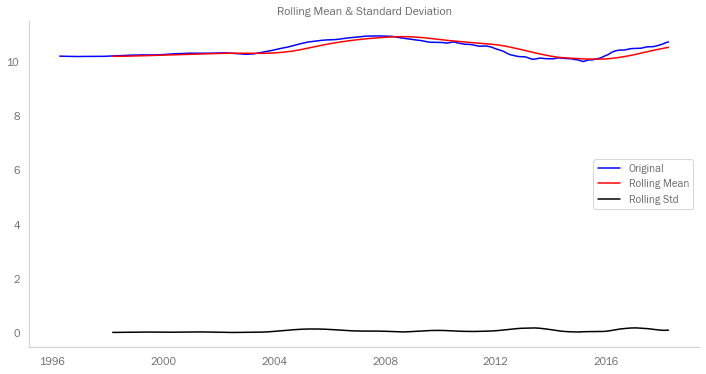

Results of Dickey-Fuller Test: 

Test Statistic                  -2.205328
p-value                          0.204317
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [66]:
# Well it doesn't appear that differencing is enough to make this data stationary.  I will try a log transform.

stationarity_check(np.log(Philly_melted))

In [67]:
find_best_difference(np.log(Philly_melted)) # Looks like 1 period difference on the log is enough!

0 nan
1 0.03194585744150177
2 0.05755421697421712
3 0.41215000402719315
4 0.3328238500504311
5 0.5219180086033582
6 0.6242970016812888
7 0.5848581976590658
8 0.6510232059347572
9 0.5855397938521867
10 0.2152804651715723
11 0.31644676563329477
12 0.3180101413235155
13 0.5066454466043491
14 0.7145389957289219
15 0.7496413895092593
16 0.9257344998971225
17 0.5027490612893842
18 0.785076746341453
19 0.4866291610367524
20 0.5239041024548403
21 0.6558632056717053
22 0.3828486937258605
23 0.15615792830432296
24 0.10144107169157374


In [68]:
find_best_difference(Indy_melted) # Similarly, Indy will also not be stationary just with differencing

# I will log transform all data from this point for consistency

0 nan
1 0.6607367844729298
2 0.6710288605269173
3 0.6538440854875729
4 0.8180384416636614
5 0.9168834702182442
6 0.7272629085524935
7 0.972985914001579
8 0.9077547267914667
9 0.9250468892100571
10 0.9475248432116631
11 0.9567961891949055
12 0.8959853887922271
13 0.8727363146890167
14 0.9364298296713139
15 0.9631269272782114
16 0.8440507229682248
17 0.7932262718023664
18 0.6247702692033436
19 0.8627990295543804
20 0.4749649338554318
21 0.4731927953954632
22 0.2701763743725465
23 0.4080676060217747
24 0.4125021871455804


In [69]:
find_best_difference(np.log(Indy_melted))

0 nan
1 0.7169611824126959
2 0.7150685269034184
3 0.7706040494740733
4 0.7316064027092836
5 0.8342752473849291
6 0.7934513927344009
7 0.9239429975367102
8 0.8022629832205488
9 0.8736470080397349
10 0.8879831714495896
11 0.9083559498230531
12 0.8595828254320502
13 0.7216980892314375
14 0.736487471121519
15 0.8862216762430716
16 0.6717269713827985
17 0.26786907914893804
18 0.28044792795807144
19 0.22406085021268823
20 0.1610621757219327
21 0.14248605509675633
22 0.05064913563009264
23 0.09326162148773787
24 0.10517892475263818


In [70]:
# I'm going to get my best difference parameter within 0-5
def find_all_best_log_differences(dfs, names):
    best_scores={}
    for idx, df in enumerate(dfs):
        lowest_score=1 # These are p-values so 1 is the highest
        for i in range(0,6):
            difference = (np.log(df)).diff(periods=i)
            dftest = adfuller(difference[i:])
            if dftest[1] < lowest_score:
                lowest_score = dftest[1]
                best_combo=(i,lowest_score)
        best_scores[names[idx]] = best_combo
    return best_scores    

best_diff = find_all_best_log_differences(all_dfs,names)
best_diff

{'Philadelphia': (1, 0.03194585744150177),
 'Indianapolis': (2, 0.7150685269034184),
 'Daytona': (5, 0.15351111071221946),
 'Columbus': (4, 0.018148301922587158),
 'KansasCity': (1, 0.14000751949106677),
 'Chattanooga': (1, 0.14039677392972233)}

### Seasonal decomposition

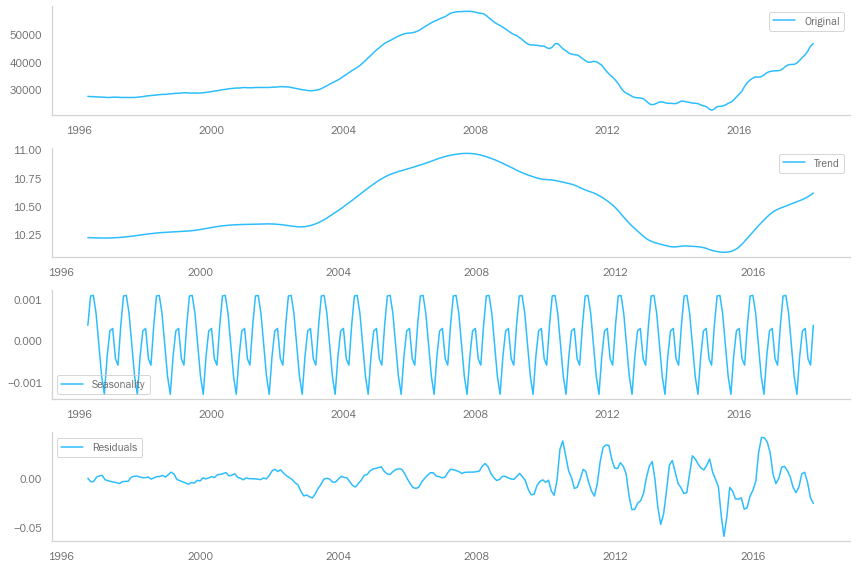

In [71]:
# I will be using logged and difference data in the models but would like to look at how decomposition works for EDA

# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(Philly_melted))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Philly_melted, label='Original')#np.log(ts)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.savefig('Images/decomposition.png')
plt.tight_layout()

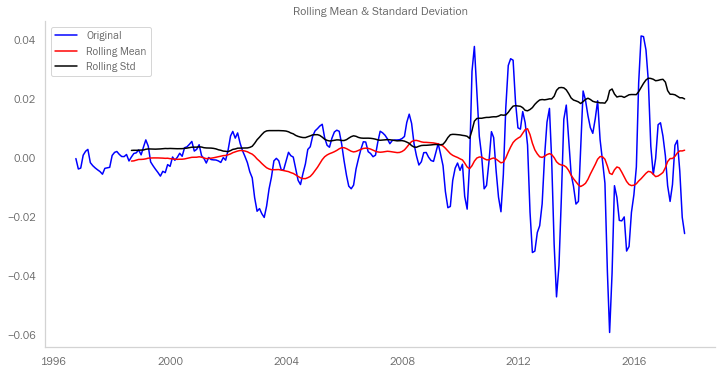

Results of Dickey-Fuller Test: 

Test Statistic                -6.009296e+00
p-value                        1.587583e-07
#Lags Used                     8.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [72]:
# Drop missing values from residuals 
Philly_residuals = residual
Philly_residuals.dropna(inplace=True)

# Check stationarity
stationarity_check(Philly_residuals)

# Although the std dev still appears to be trending upward, the p-value indicates stationarity

### Correlation

In [73]:
# To check correlation lets concat all series together
df_group = pd.concat(all_dfs, axis=1)
df_group.columns = names
df_group.corr()

# Highly correlated but they are not stationary at this point

,Philadelphia,Indianapolis,Daytona,Columbus,KansasCity,Chattanooga
Philadelphia,1.000000,0.928714,0.788810,0.937542,0.568138,0.856833
Indianapolis,0.928714,1.000000,0.869279,0.933518,0.898426,0.928332
Daytona,0.788810,0.869279,1.000000,0.936875,0.829742,0.864986
Columbus,0.937542,0.933518,0.936875,1.000000,0.901098,0.882271
KansasCity,0.568138,0.898426,0.829742,0.901098,1.000000,0.777869
Chattanooga,0.856833,0.928332,0.864986,0.882271,0.777869,1.000000


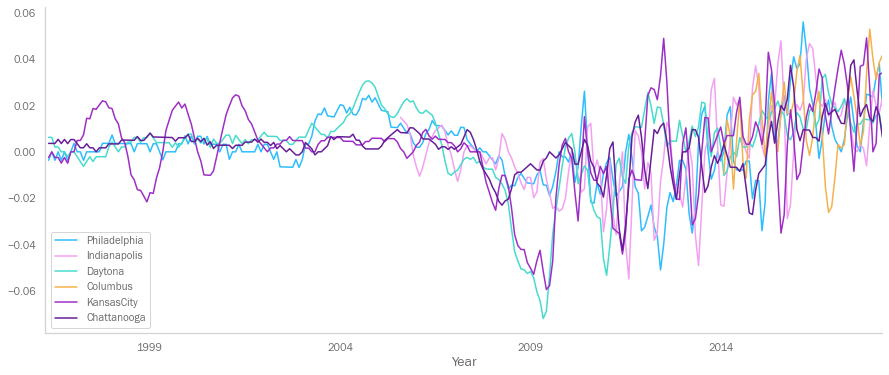

In [74]:
# Let's difference them all then check correlation again
df_group_diff = np.log(df_group).diff(periods=1)
df_group_diff.plot(figsize=(15,6))
plt.xlabel('Year', fontsize=14)
plt.savefig('Images/zips_differenced.png');

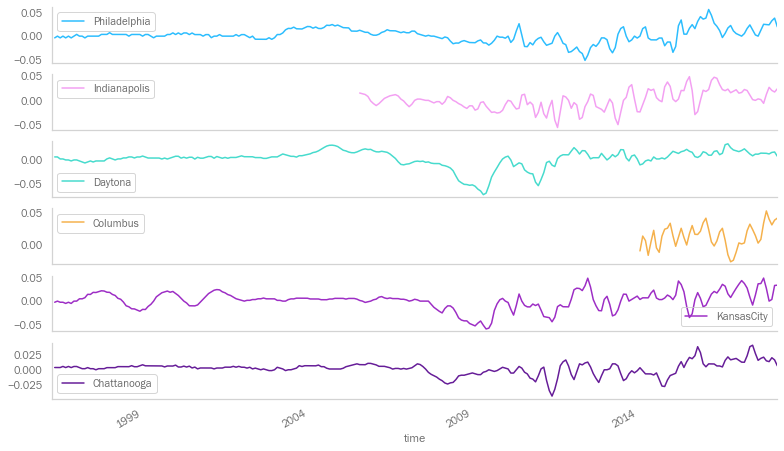

In [75]:
df_group_diff.plot(figsize=(13,8), subplots=True, legend=True)
plt.savefig('Images/differenced_subplots.png');

In [76]:
df_group_diff.corr() # Less correlated when they are differenced 1 period, nothing over .639

,Philadelphia,Indianapolis,Daytona,Columbus,KansasCity,Chattanooga
Philadelphia,1.000000,0.368891,0.378077,0.319255,0.267676,0.443239
Indianapolis,0.368891,1.000000,0.388933,0.055788,0.372529,0.250858
Daytona,0.378077,0.388933,1.000000,-0.080285,0.639956,0.431938
Columbus,0.319255,0.055788,-0.080285,1.000000,-0.048437,0.103480
KansasCity,0.267676,0.372529,0.639956,-0.048437,1.000000,0.393031
Chattanooga,0.443239,0.250858,0.431938,0.103480,0.393031,1.000000


### ACF and PACF

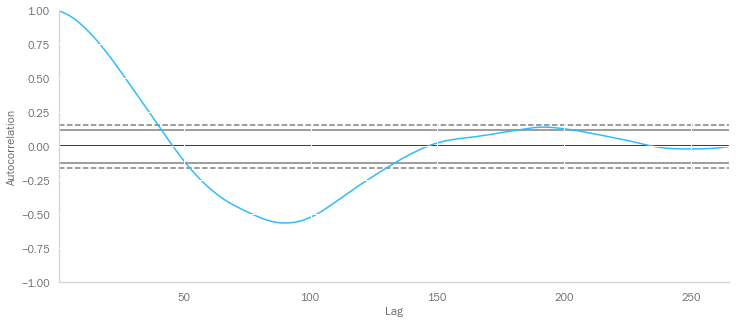

In [77]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(Philly_melted);
# Don't see spikes for yearly correlations

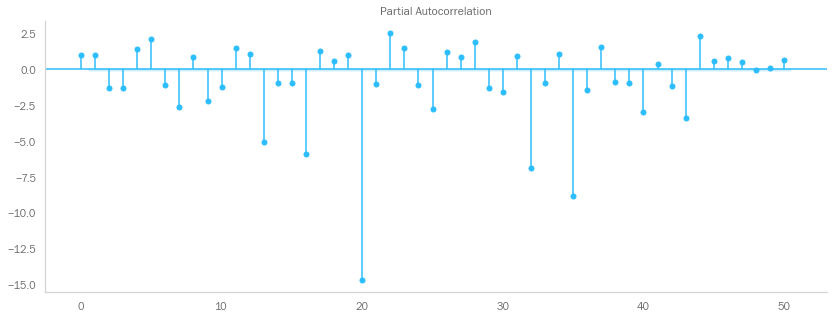

In [78]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(Philly_melted, lags=50);

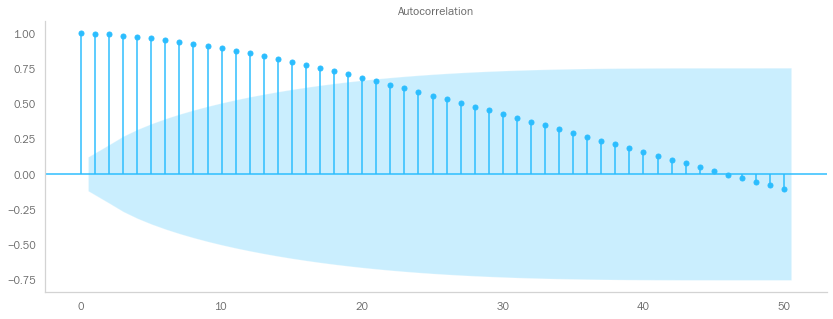

In [79]:
from statsmodels.graphics.tsaplots import plot_acf

rcParams['figure.figsize'] = 14, 5

plot_acf(Philly_melted, lags=50);

## Train Test Split

In [80]:
# My times series have different lengths, some are very short
# I originally split the testing data to be 20% of the data, rather than a particular time period
# However, my training data failed to capture the recent upward trends
# So now I will segment the test/forecasting data to only the most recent year
# Function takes in a list for scalability
# We already created the list and names for a previous function

def test_split(list_of_df, names):
    return_list=[]
    for i, df in enumerate(list_of_df):
#         test_nobs=int((len(df))*.20)
#         training_data = df[:-(test_nobs)]
#         test_data = df[-(test_nobs):]
        training_data = df[:-12]
        test_data = df[-12:]
        return_list.extend([training_data, test_data])
        print(names[i], ': ', df.shape, 'Train: ', training_data.shape, 'Test: ', test_data.shape)
    return return_list

Philly_train, Philly_test, Indy_train, Indy_test, Daytona_train, Daytona_test, \
    Columbus_train, Columbus_test, KC_train, KC_test, Chattanooga_train, Chattanooga_test = test_split(all_dfs, names)


Philadelphia :  (265, 1) Train:  (253, 1) Test:  (12, 1)
Indianapolis :  (154, 1) Train:  (142, 1) Test:  (12, 1)
Daytona :  (265, 1) Train:  (253, 1) Test:  (12, 1)
Columbus :  (52, 1) Train:  (40, 1) Test:  (12, 1)
KansasCity :  (265, 1) Train:  (253, 1) Test:  (12, 1)
Chattanooga :  (265, 1) Train:  (253, 1) Test:  (12, 1)


In [81]:
Columbus_test

,value
time,
2017-05-01,63900.0
2017-06-01,66000.0
2017-07-01,67600.0
2017-08-01,68600.0
2017-09-01,68800.0
2017-10-01,69400.0
2017-11-01,71800.0
2017-12-01,75700.0
2018-01-01,78800.0


In [82]:
# Making lists to run through models together
all_train_df = [Philly_train, Indy_train, Daytona_train, Columbus_train, KC_train, Chattanooga_train]
all_test_df = [Philly_test, Indy_test, Daytona_test, Columbus_test, KC_test, Chattanooga_test]

## Baseline ARIMA modeling

<pre>

    Name             Order     Seasonal_Order  Fit_Time   Const      ar.L1   ma.L1   sigma2     AIC Score
0   Philadelphia    (1, 0, 1)   (0, 0, 0, 0)    0.1751   36279.03   0.9975  0.7643  105736.54   3660.12
1   Indianapolis    (1, 0, 1)   (0, 0, 0, 0)    0.1616   56143.06   0.9971  0.8044  365498.65   2237.24
2   Daytona         (1, 0, 1)   (0, 0, 0, 0)    0.1536   65794.06   0.9976  0.9413  541074.22   4074.94
3   Columbus        (1, 0, 1)   (0, 0, 0, 0)    0.0608   54074.93   0.9913  0.9994  362743.00    642.68
4   Kansas City     (1, 0, 1)   (0, 0, 0, 0)    0.1556   48263.62   0.9970  0.8875  209724.01   3834.07
5   Chattanooga     (1, 0, 1)   (0, 0, 0, 0)    0.2144   70698.40   0.9979  0.8266  167378.79   3776.88
</pre>

In [84]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Establish a metrics dataframe to store models
column_metrics = ['Name', 'Order', 'Seasonal_Order', 'Fit_Time', 
                  'Const', 'ar.L1', 'ma.L1', 'sigma2', 'AIC Score']
metrics_df = pd.DataFrame(columns = column_metrics)

# Start with a baseline model of AR(1) and MA(1)
order=(1,0,1)

for i, train_df in enumerate(all_train_df):
    metrics_df = run_arima_models(names[i], train_df, all_test_df[i], order, metrics_df) # Function in user_functions.py

metrics_df

,Name,Order,Seasonal_Order,Fit_Time,Const,ar.L1,ma.L1,sigma2,AIC Score
0,Philadelphia,"(1, 0, 1)","(0, 0, 0, 0)",0.1721,36279.03,0.9975,0.7643,105736.54,3660.12
1,Indianapolis,"(1, 0, 1)","(0, 0, 0, 0)",0.1517,56143.06,0.9971,0.8044,365498.65,2237.24
2,Daytona,"(1, 0, 1)","(0, 0, 0, 0)",0.1566,65794.06,0.9976,0.9413,541074.22,4074.94
3,Columbus,"(1, 0, 1)","(0, 0, 0, 0)",0.0579,54074.93,0.9913,0.9994,362743.00,642.68
4,KansasCity,"(1, 0, 1)","(0, 0, 0, 0)",0.1406,48263.62,0.9970,0.8875,209724.01,3834.07
5,Chattanooga,"(1, 0, 1)","(0, 0, 0, 0)",0.2084,70698.40,0.9979,0.8266,167378.79,3776.88


## Find Optimal p,d,q

### Philly

<pre>
pdq         (2, 1, 2)
pdqs    (1, 0, 1, 12)
aic          -1818.25
Name: 226, dtype: object
</pre>

In [89]:
# Putting in the best d value calculated earlier saves a lot of time in the grid search, though potentially gives 
# different values

tic = time.time()
Philly_grid_search = grid_search_arima(np.log(Philly_train), 
                                       d = best_diff['Philadelphia'][0]) # Function in user_functions.py
print(time.time()-tic)

pdq         (2, 1, 2)
pdqs    (1, 0, 1, 12)
aic          -1818.25
Name: 226, dtype: object
406.09337639808655


In [90]:
'''There is no problem with a positive log-likelihood. It is a common misconception that the log-likelihood must be 
negative.  If the likelihood is derived from a probability density it can quite reasonably exceed 1 which means that
log-likelihood is positive, hence the deviance and the AIC are negative. This is what occurred in your model.

If you believe that comparing AICs is a good way to choose a model then it would still be the case that the (algebraically)
lower AIC is preferred not the one with the lowest absolute AIC value. To reiterate you want the most negative number in
your example.'''

'There is no problem with a positive log-likelihood. It is a common misconception that the log-likelihood must be \nnegative.  If the likelihood is derived from a probability density it can quite reasonably exceed 1 which means that\nlog-likelihood is positive, hence the deviance and the AIC are negative. This is what occurred in your model.\n\nIf you believe that comparing AICs is a good way to choose a model then it would still be the case that the (algebraically)\nlower AIC is preferred not the one with the lowest absolute AIC value. To reiterate you want the most negative number in\nyour example.'

In [91]:
Philly_model = ARIMA(np.log(Philly_train), order=(2,1,2), seasonal_order=(1,0,1,12), freq='MS')
Philly_results = Philly_model.fit()
print(Philly_results.aic)

-1818.2534500111883


In [92]:
# Because so many values came up as '2' in my grid search, I would like to expand my grid to higher values.
tic = time.time()
p = d = q = range(2, 5)
pdq = list(itertools.product(p, d, q))
pdqs = [(1,0,1,12)]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            grid_model = ARIMA(np.log(Philly_train), order=comb, seasonal_order=combs, freq='MS')
            grid_results = grid_model.fit()
            ans.append([comb, combs, grid_results.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, results.aic))
        except:
            continue
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])
print(time.time()-tic)

pdq         (2, 2, 3)
pdqs    (1, 0, 1, 12)
aic          -1822.04
Name: 1, dtype: object
22.31398868560791


In [93]:
# So with (2,1,2) aic was -1818. With (2,2,3) aic is -1822. I'm not sure that is enough difference to justify the
# addition of the extra parameters

In [94]:
Philly_metrics = track_final_metrics(Philly_grid_search, Philly_results, names[0]) # function in user_functions.py

### Indy

<pre>
pdq         (1, 2, 2)
pdqs    (2, 0, 2, 12)
aic          -867.448
Name: 155, dtype: object
</pre>

In [95]:
tic = time.time()
Indy_grid_search = grid_search_arima(np.log(Indy_train), d = best_diff['Indianapolis'][0])
print(time.time()-tic)

pdq         (1, 2, 2)
pdqs    (2, 0, 2, 12)
aic          -867.448
Name: 155, dtype: object
344.0089054107666


In [96]:
Indy_model = ARIMA(np.log(Indy_train), order=(1,2,2), seasonal_order=(2,0,2,12), freq='MS')
Indy_results = Indy_model.fit()
print(Indy_results.aic)

-867.4478406929932


In [97]:
Indy_metrics = track_final_metrics(Indy_grid_search, Indy_results, names[1]) # function in user_functions.py

### Daytona

<pre>
pdq         (0, 5, 2)
pdqs    (0, 0, 0, 12)
aic          -1824.65
Name: 54, dtype: object
</pre>

In [98]:
tic = time.time()
Daytona_grid_search = grid_search_arima(np.log(Daytona_train), d = best_diff['Daytona'][0])
print(time.time()-tic)

pdq         (0, 5, 2)
pdqs    (0, 0, 0, 12)
aic          -1824.65
Name: 54, dtype: object
666.3722267150879


In [99]:
Daytona_grid_search

,pdq,pdqs,aic
0,"(0, 5, 0)","(0, 0, 0, 12)",-1414.539641
1,"(0, 5, 0)","(0, 0, 1, 12)",-1417.087372
2,"(0, 5, 0)","(0, 0, 2, 12)",-1413.983055
3,"(0, 5, 0)","(0, 1, 0, 12)",-1151.848313
4,"(0, 5, 0)","(0, 1, 1, 12)",-1288.018780
...,...,...,...
238,"(2, 5, 2)","(2, 1, 1, 12)",-1459.375987
239,"(2, 5, 2)","(2, 1, 2, 12)",-1504.250667
240,"(2, 5, 2)","(2, 2, 0, 12)",-1249.043222
241,"(2, 5, 2)","(2, 2, 1, 12)",-1243.620754


In [100]:
Daytona_model = ARIMA(np.log(Daytona_train), order=(0,5,2), seasonal_order=(0,0,0,12), freq='MS')
Daytona_results = Daytona_model.fit()
print(Daytona_results.aic)

-1824.6532776198896


In [101]:
Daytona_metrics = track_final_metrics(Daytona_grid_search, Daytona_results, names[2]) # function in user_functions.py

### Columbus

<pre>
pdq         (2, 4, 1)
pdqs    (1, 0, 0, 12)
aic          -194.596
Name: 198, dtype: object
</pre>

In [102]:
tic = time.time()
Columbus_grid_search = grid_search_arima(np.log(Columbus_train), d = best_diff['Columbus'][0])
print(time.time()-tic)

pdq         (2, 4, 1)
pdqs    (1, 0, 0, 12)
aic          -194.596
Name: 198, dtype: object
188.4361650943756


In [103]:
Columbus_model = ARIMA(np.log(Columbus_train), order=(2,4,1), seasonal_order=(1,0,0,12), freq='MS')
Columbus_results = Columbus_model.fit()
print(Columbus_results.aic)

-194.5958648817607


In [104]:
Columbus_metrics = track_final_metrics(Columbus_grid_search, Columbus_results, names[3]) # function in user_functions.py

### Kansas City

<pre>
pdq         (1, 1, 2)
pdqs    (0, 0, 2, 12)
aic          -1801.54
Name: 137, dtype: object
</pre>

In [105]:
tic = time.time()
KC_grid_search = grid_search_arima(np.log(KC_train), d = best_diff['KansasCity'][0])
print(time.time()-tic)

pdq         (1, 1, 2)
pdqs    (0, 0, 2, 12)
aic          -1801.54
Name: 137, dtype: object
439.79084300994873


In [106]:
KC_model = ARIMA(np.log(KC_train), order=(1,1,2), seasonal_order=(0,0,2,12), freq='MS')
KC_results = KC_model.fit()
print(KC_results.aic)

-1801.535745337077


In [107]:
KC_metrics = track_final_metrics(KC_grid_search, KC_results, names[4]) # function in user_functions.py

### Chattanooga

<pre>
pdq         (1, 1, 2)
pdqs    (0, 0, 2, 12)
aic          -2068.06
Name: 137, dtype: object
</pre>

In [108]:
tic = time.time()
Chattanooga_grid_search = grid_search_arima(np.log(Chattanooga_train), d = best_diff['Chattanooga'][0])
print(time.time()-tic)

pdq         (1, 1, 2)
pdqs    (0, 0, 2, 12)
aic          -2068.06
Name: 137, dtype: object
392.2059817314148


In [109]:
Chattanooga_model = ARIMA(np.log(Chattanooga_train), order=(1,1,2), seasonal_order=(0,0,2,12), freq='MS')
Chattanooga_results = Chattanooga_model.fit()
print(Chattanooga_results.aic)

-2068.064330716703


In [110]:
Chattanooga_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            value   No. Observations:                  253
Model:             ARIMA(1, 1, 2)x(0, 0, 2, 12)   Log Likelihood                1040.032
Date:                          Wed, 27 Jan 2021   AIC                          -2068.064
Time:                                  23:37:21   BIC                          -2046.888
Sample:                              04-01-1996   HQIC                         -2059.543
                                   - 04-01-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7161      0.039     18.303      0.000       0.639       0.793
ma.L1          0.7526      0.049     15.384      0.000       0.657       0.848
ma.L2          0.2969      0.044      6.726      0.000       0.210       0.383
ma.S.L12      -0.1871      0.064     -2.938      0.003      -0.312      -0.062
ma.S.L24      -0.1307      0.057     -2.282      0.022      -0.243      -0.018
sigma2      1.501e-05   9.31e-07     16.111      0.000    1.32e-05    1.68e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               172.83
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               8.97   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
Chattanooga_metrics = track_final_metrics(Chattanooga_grid_search, Chattanooga_results, names[5])

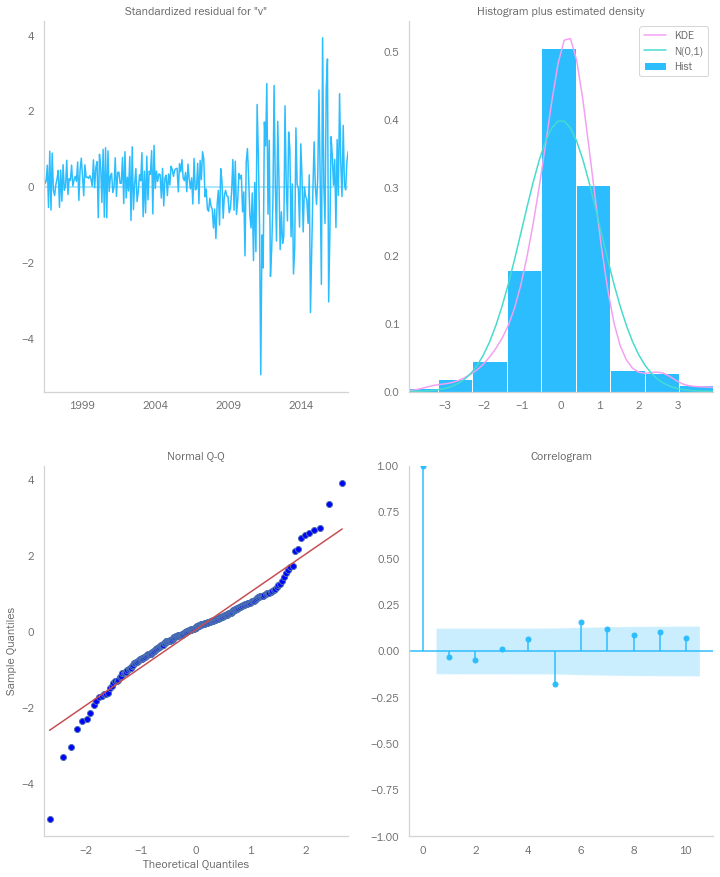

In [115]:
Chattanooga_results.plot_diagnostics(figsize=(12, 15))
plt.savefig('Images/Chat_diagnostics.png')

## Visualize predictions and Calculate RMSE for top models

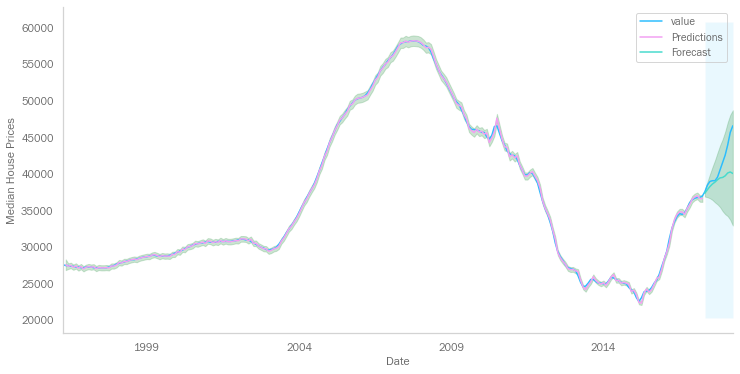

The Root Mean Squared Error of Philadelphia predictions is 210.12
The Root Mean Squared Error of Philadelphia forecasts is 2904.6


TypeError: descriptor 'date' for 'datetime.datetime' objects doesn't apply to a 'int' object

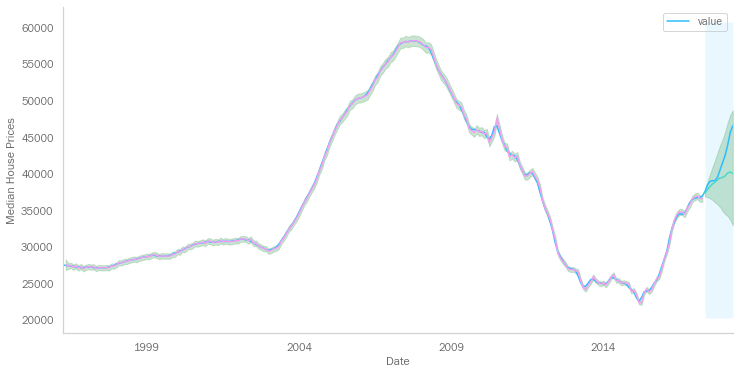

In [140]:
Philly_pred, Philly_forecast, Philly_train_rmse, Philly_test_rmse = \
    run_preds_and_plot(Philly_results, Philly_train, Philly_test, 'Philadelphia', best_diff)
Philly_metrics.update({'train rmse': Philly_train_rmse, 'test rmse': Philly_test_rmse})

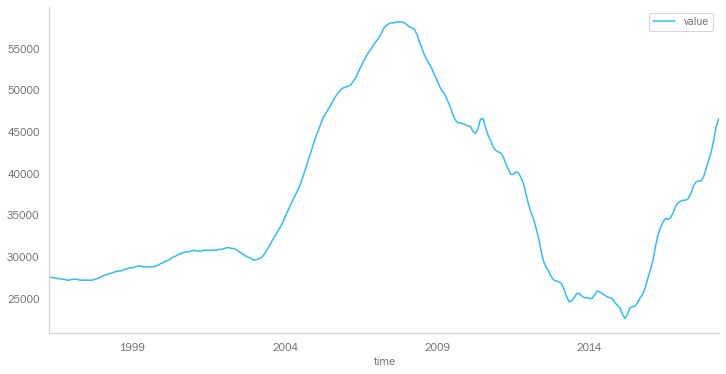

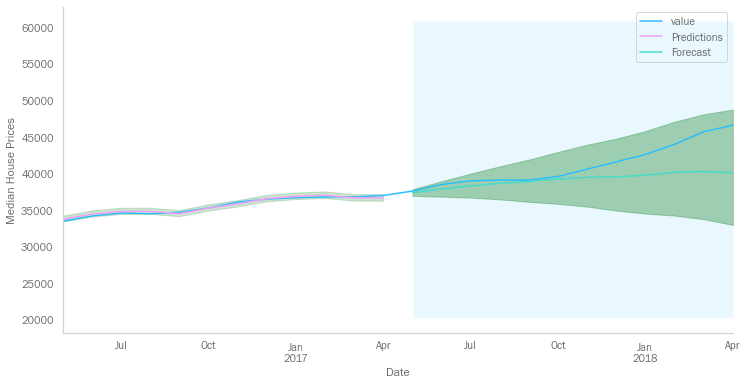

In [139]:
pred = Philly_results.get_prediction(start=best_diff[names[0]][0])
pred_forecast = Philly_results.get_forecast(steps=pd.to_datetime(Philly_test.index[-1]), dynamic=True)
pred_conf = pred.conf_int()
pred_forecast_conf = pred_forecast.conf_int()

all_data = pd.concat([Philly_train, Philly_test], axis=0)
ax = all_data.plot(label='observed', figsize=(12, 6))
np.exp(pred.predicted_mean).plot(label='Predictions', ax=ax)
np.exp(pred_forecast.predicted_mean).plot(label='Forecast', ax=ax)
ax.fill_between(np.exp(pred_conf).index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=.3)
# Limit upper end of confidence interval so it doesn't blow up the graph
bound_conf=[]
for i in range(len(pred_forecast_conf)):
    if np.exp(pred_forecast_conf).iloc[i,1] > 1.5*np.exp(pred_forecast.predicted_mean)[-1]:
        bound_conf.append(1.5*np.exp(pred_forecast.predicted_mean)[-1])
    else:
        bound_conf.append(np.exp(pred_forecast_conf).iloc[i,1])
bound_df = pd.DataFrame(bound_conf, index=pred_forecast_conf.index, columns=['upper value'])
   
ax.fill_between(np.exp(pred_forecast_conf).index,
                np.exp(pred_forecast_conf).iloc[:, 0],
                bound_df.iloc[:, 0], color='g', alpha=.3)
ax.fill_between(np.exp(pred_forecast_conf).index,
                np.exp(pred_forecast_conf).iloc[:, 0],
                bound_df.iloc[:, 0], color='g', alpha=.3)
ax.fill_betweenx(ax.get_ylim(), Philly_test.index[0], Philly_test.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Median House Prices')
ax.set_xlim(xmin=Philly_train.index[-12])
plt.legend()
imagename=str("Images/2yr"+names[0][0]+"pred.png")
plt.savefig(imagename)
plt.show()

In [ ]:
Indy_pred, Indy_forecast, Indy_train_rmse, Indy_test_rmse = run_preds_and_plot(Indy_results, 
                                                                               Indy_train, Indy_test, 'Indianapolis')
Indy_metrics.update({'train rmse': Indy_train_rmse, 'test rmse': Indy_test_rmse})

In [ ]:
Daytona_pred, Daytona_forecast, Daytona_train_rmse, Daytona_test_rmse = \
    run_preds_and_plot(Daytona_results, Daytona_train, Daytona_test, 'Daytona')
Daytona_metrics.update({'train rmse': Daytona_train_rmse, 'test rmse': Daytona_test_rmse})

In [ ]:
Columbus_pred, Columbus_forecast, Columbus_train_rmse, Columbus_test_rmse = \
    run_preds_and_plot(Columbus_results, Columbus_train, Columbus_test, 'Columbus')
Columbus_metrics.update({'train rmse': Columbus_train_rmse, 'test rmse': Columbus_test_rmse})

In [ ]:
KC_pred, KC_forecast, KC_train_rmse, KC_test_rmse = run_preds_and_plot(KC_results, KC_train, KC_test, 'Kansas City')
KC_metrics.update({'train rmse': KC_train_rmse, 'test rmse': KC_test_rmse})

In [ ]:
Chattanooga_pred, Chattanooga_forecast, Chattanooga_train_rmse, Chattanooga_test_rmse = \
    run_preds_and_plot(Chattanooga_results, Chattanooga_train, Chattanooga_test, 'Chattanooga')
Chattanooga_metrics.update({'train rmse': Chattanooga_train_rmse, 'test rmse': Chattanooga_test_rmse})

## Interpret Results / Conclusions

In [ ]:
pd.DataFrame([Philly_metrics, Indy_metrics, Daytona_metrics, Columbus_metrics, KC_metrics, Chattanooga_metrics])

Results: 

Caveats: 
* Logged and differenced the data but some still did not test as stationary according to the Dickey Fuller test.
* Real estate predictions can vary due to unseen fluctuations in the market

Next Steps/Future Work: 
* Obtain current data after 2018 for current predictions. Found zip data on Redfin but it is rolling avg by zip code.
